### AutoML

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from utils import plot_cm

# AutoML
import automl
from automl import init

In [2]:
SEED = 42
TRAIN_FRAC = 0.8
TARGET = "Churn"

NAMESPACE = "frqap2zhtzbe"
BUCKET = "WORKSHOP"
NOME_FILE = "customer_churn_data.csv"

URL = f"oci://{BUCKET}@{NAMESPACE}/{NOME_FILE}"

orig_df = pd.read_csv(URL)

orig_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df = orig_df.copy()

y = pd.Series(df[TARGET])

df_x = df.drop(columns=[TARGET])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_x, y,
                                                    train_size=TRAIN_FRAC ,
                                                    random_state=SEED)

print(f"We have {X_train.shape[0]} samples in train dataset")
print(f"We have {X_test.shape[0]} samples in test dataset")

We have 5634 samples in train dataset
We have 1409 samples in test dataset


#### Auto ML session

In [5]:
automl.init(engine='local')

[2023-03-22 10:03:17,516] [automl.xengine] Local ProcessPool execution (n_jobs=8)


In [6]:
MODEL_LIST = ['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier', 'LogisticRegression']

est = automl.Pipeline(task='classification', model_list = MODEL_LIST, 
                      n_algos_tuned = len(MODEL_LIST), 
                      min_features = 20,
                      score_metric = ['accuracy'], random_state=SEED)

[2023-03-22 10:03:18,153] [automl.pipeline] Random state (42) is used for model builds


In [7]:
est.fit(X_train, y_train, cv=5, time_budget=900)

[2023-03-22 10:03:19,186] [automl.pipeline] Dataset shape: (5634, 20)
[2023-03-22 10:03:19,217] [automl.pipeline] Running Auto-Preprocessing
[2023-03-22 10:03:19,487] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (5634, 44), cv: 5
[2023-03-22 10:03:19,585] [automl.pipeline] Running Model Selection
[2023-03-22 10:03:24,933] [automl.pipeline] Model Selection completed. Selected model: ['XGBClassifier', 'RandomForestClassifier', 'LGBMClassifier', 'LogisticRegression']
[2023-03-22 10:03:24,934] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (5634, 44), Valid Shape: None, CV: 5, Class counts: [4138 1496]
[2023-03-22 10:03:26,983] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (5634, 44), Valid Shape: None, CV: [(2811, 1127), (2811, 1127), (2811, 1127), (2810, 1127), (2811, 1126)], Class counts: [4138 1496]
[2023-03-22 10:03:26,985] [automl.pipeline] Starting Feature Selection 0. Dataset Shape: (5634, 44)
[2023-03-22 10:03:43,545] [auto

Pipeline(min_features=20,
         model_list=['LGBMClassifier', 'XGBClassifier',
                     'RandomForestClassifier', 'LogisticRegression'],
         random_state=42)

In [8]:
est.print_summary()

Training Dataset size,"(5634, 20)"
Validation Dataset size,None
CV,5
Optimization Metric,accuracy
Selected Features,"Index(['gender_1', 'gender_2', 'SeniorCitizen', 'Partner_1', 'Partner_2', 'tenure', 'MultipleLines_1', 'MultipleLines_3', 'InternetService_2', 'OnlineSecurity_1', 'OnlineSecurity_3', 'OnlineBackup_1', 'DeviceProtection_1', 'TechSupport_1', 'Contract_1', 'Contract_2', 'Contract_3', 'PaperlessBilling_1', 'PaperlessBilling_2', 'PaymentMethod_1', 'PaymentMethod_2', 'PaymentMethod_3', 'MonthlyCharges'], dtype='object')"
Selected Algorithm,LGBMClassifier
Time taken,163.9388
Selected Hyperparameters,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 6, 'n_jobs': 16, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.018783319485647054, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}"
AutoML version,23.1.1
Python version,"3.8.16 (default, Mar 2 2023, 03:21:46) \n[GCC 11.2.0]"


Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
XGBClassifier_AS,5000,44,0.7993,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",3.1522,0.0
LGBMClassifier_HT,5634,23,0.7879,"{'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 6, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0.018783319485647054}",0.1814,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.7879,"{'boosting_type': 'dart', 'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 6, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0.018783319485647054}",0.1360,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.7879,"{'boosting_type': 'goss', 'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 6, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0.018783319485647054}",0.1410,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.7863,"{'boosting_type': 'dart', 'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 7, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1}",0.1584,"(0.0, None)"
...,...,...,...,...,...,...
LGBMClassifier_HT,5634,23,0.6541,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 0.0031722934713580386}",0.1193,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.6541,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 0.999990000000001}",0.1120,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.6541,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1}",0.1005,"(0.0, None)"
LGBMClassifier_HT,5634,23,0.6541,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 6, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.1048,"(0.0, None)"


#### Evaluation

In [11]:
test_pred = est.predict(X_test)
test_probas = est.predict_proba(X_test)

print('Test set result:')

roc_auc = round(roc_auc_score(y_test, test_probas[:,1]), 4)
acc = round(accuracy_score(y_test, test_pred), 4)

# this is the Object that can be saved in the Model Catalog
metrics = {
    "accuracy" : acc,
    "roc_auc" : roc_auc
}

print(str(metrics))

Test set result:
{'accuracy': 0.7786, 'roc_auc': 0.8574}


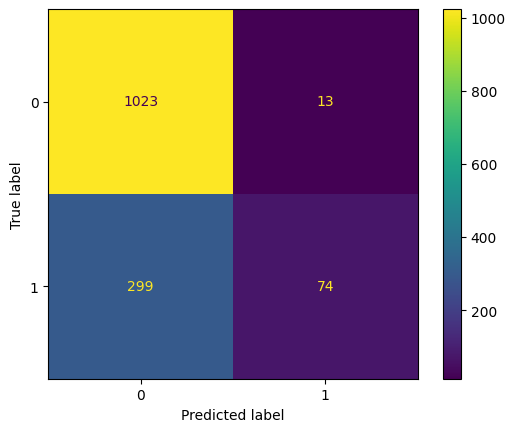

In [12]:
plot_cm(est, X_test, y_test)

### Si può vedere che il modello funziona particolarmente male sui positivi (troppi FN)